In [1]:
import pandas as pd
# I only need first four columns
df = pd.read_csv('Usage data.csv', usecols=[0,1,2,3,4])
# I want to read data from rows 88 to 605
df = df.iloc[86:605]
df.head()

,TimeStamp,ResourceType,ResourceID,Effectiveness,Percentage
86,01-Jan-22,Cloud Storage,Data Scenarios,Cost,30.0
87,02-Jan-22,Cloud Storage,Data Scenarios,Cost,33.0
88,03-Jan-22,Cloud Storage,Data Scenarios,Cost,31.0
89,04-Jan-22,Cloud Storage,Data Scenarios,Cost,37.0
90,05-Jan-22,Cloud Storage,Data Scenarios,Cost,33.0


In [2]:
# Delete column ResourceType, ResourceId, and Effectiveness from the dataframe
df = df.drop(['ResourceType', 'ResourceID', 'Effectiveness'], axis=1)
df.head()

,TimeStamp,Percentage
86,01-Jan-22,30.0
87,02-Jan-22,33.0
88,03-Jan-22,31.0
89,04-Jan-22,37.0
90,05-Jan-22,33.0


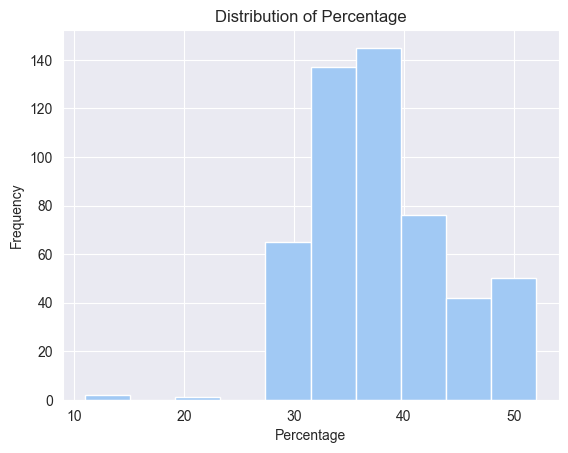

In [3]:
# find distribution of the percentage column using graph
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_palette('pastel')
sns.set_style('darkgrid')
plt.hist(df['Percentage'])
plt.xlabel('Percentage')
plt.ylabel('Frequency')
plt.title('Distribution of Percentage')
plt.show()

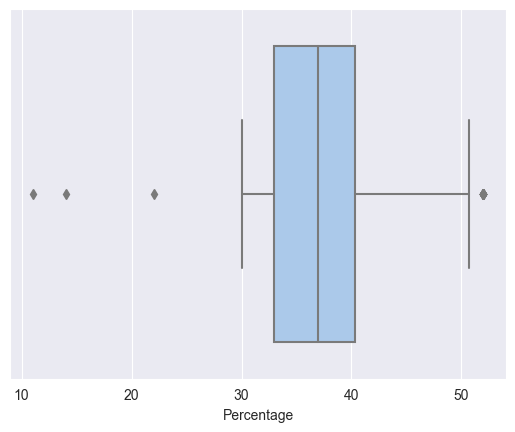

In [4]:
#create a box plot to find outliers
sns.boxplot(x=df['Percentage'])
plt.show()

In [5]:
# convert timestamp column to datetime format
df['TimeStamp'] = pd.to_datetime(df['TimeStamp'])

In [6]:
print(f"starting date : {str(df['TimeStamp'].dt.date.min())}")
print(f"end date : {str(df['TimeStamp'].dt.date.max())}")

starting date : 2022-01-01
end date : 2023-06-02


In [7]:
# Quantile Range
Q1 = df['Percentage'].quantile(0.20)
Q3 = df['Percentage'].quantile(0.80)
IQR = Q3 - Q1

In [8]:
#Calculate number of outliers in a column
((df['Percentage'] < (Q1 - 1.5 * IQR)) | (df['Percentage'] > (Q3 + 1.5 * IQR))).sum()

2

In [9]:
# show the outliers
df['Percentage'][((df['Percentage'] < (Q1 - 1.5 * IQR)) | (df['Percentage'] > (Q3 + 1.5 * IQR)))]

394    11.0
420    14.0
Name: Percentage, dtype: float64

In [10]:
x = df['TimeStamp'].values.reshape(-1, 1)
y = df['Percentage'].values.reshape(-1, 1)

In [11]:
# train test split
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, shuffle=False, test_size=0.2)

In [12]:
# use linear regression model
from sklearn.linear_model import LinearRegression
reg = LinearRegression()
reg.fit(x_train, y_train)


LinearRegression()

In [13]:
#predict the values
y_pred = reg.predict(x_test)

In [14]:
#calculate mae score
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(y_test, y_pred)
print(mae)
#calculate MSE
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_test, y_pred)
print(mse)
#calculate RMSE
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse = sqrt(mean_squared_error(y_test, y_pred))
print(rmse)

6.275464827712623
55.760095583294465
7.467268281191889


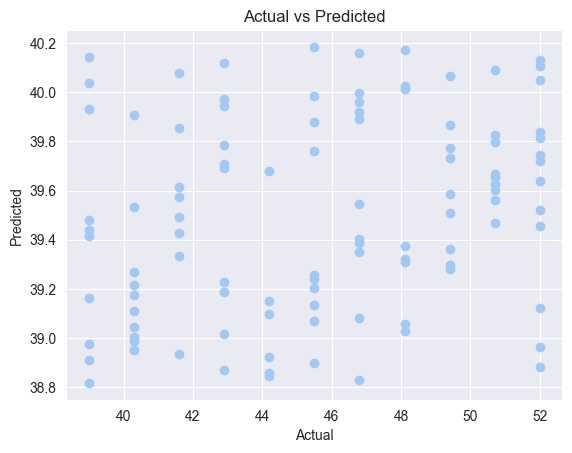

In [15]:
# create a scatter plot between actual and predicted values
plt.scatter(y_test, y_pred)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted')
plt.show()

In [16]:
# use gradient boosting regressor
import numpy as np
from sklearn.ensemble import GradientBoostingRegressor
y_train = np.ravel(y_train)
gbr = GradientBoostingRegressor()
gbr.fit(x_train, y_train)


GradientBoostingRegressor()

In [17]:
#predict the values
y_pred = gbr.predict(x_test)

In [18]:
#calculate mae score
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(y_test, y_pred)
print(mae)
#calculate MSE
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_test, y_pred)
print(mse)
#calculate RMSE
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse = sqrt(mean_squared_error(y_test, y_pred))
print(rmse)

4.680795056232784
32.228392524044935
5.677005594857639


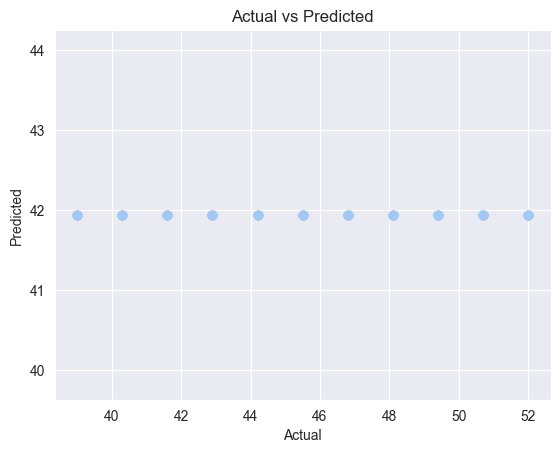

In [19]:
# create a scatter plot between actual and predicted values
plt.scatter(y_test, y_pred)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted')
plt.show()